<a href="https://colab.research.google.com/github/jsansao/dlvc/blob/main/Licao19_VGGFACE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Lição 19 - Reconhecimento Facial com VGGFACE2




## Instalação 

O pacote original tem uma incompatibilidade com o Keras na versão mais recente, por isso foi feito um fork. 

Deve-se instalar também o mtcnn para detecção da face e o keras_applications. 

In [1]:
!pip install git+https://github.com/jsansao/keras-vggface.git
!pip install mtcnn
!pip install keras_applications

  Cloning https://github.com/jsansao/keras-vggface.git to /tmp/pip-req-build-q9rbv_1a
  Running command git clone -q https://github.com/jsansao/keras-vggface.git /tmp/pip-req-build-q9rbv_1a
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8315 sha256=ebd02a3cb89eb879bc0f6fc86da3397cf4b6dcc0c0ceca03ce309e8ed21a47b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-gylm1zos/wheels/17/1d/de/3357313e72504b373dcd31226714c9477da009000aeb307586
Successfully built keras-vggface
     |████████████████████████████████| 2.3 MB 4.2 MB/s 
     |████████████████████████████████| 50 kB 2.6 MB/s 


In [2]:
!pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: h5py, numpy, keras, pyyaml, pillow, scipy, six
Required-by: 


In [3]:
from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image
from numpy import asarray

import mtcnn
from keras.utils.layer_utils import get_source_inputs

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
 

## Inferência no conjunto pré-treinado com o dataset VGGFACE-2 

In [22]:
model = VGGFace(model='resnet50')
# summarize input and output shape
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_23')>]
Outputs: [<KerasTensor: shape=(None, 8631) dtype=float32 (created by layer 'classifier')>]


In [71]:
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = mtcnn.MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array


In [83]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving 4.johnny-depp-amber-heard.jpg to 4.johnny-depp-amber-heard.jpg
User uploaded file "4.johnny-depp-amber-heard.jpg" with length 289753 bytes


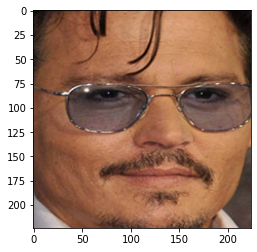

b' Johnny_Depp': 99.846%
b' Emilio_Rivera': 0.038%
b' Joseph_Estrada': 0.030%
b' Billy_Crystal': 0.007%
b' Gary_Oldman': 0.004%


In [84]:
# load the photo and extract the face
pixels = extract_face(fn)
# plot the extracted face
pyplot.imshow(pixels)
# show the plot
pyplot.show()
# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)
# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)
# create a vggface model
model = VGGFace(model='resnet50')
# perform prediction
yhat = model.predict(samples)
# convert prediction into names
results = decode_predictions(yhat)
# display most likely results
for result in results[0]:
	print('%s: %.3f%%' % (result[0], result[1]*100))

## Verificação facial com VGGFace2


In [85]:
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

94707712/94694792 [==============================] - 6s 0us/step


In [102]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = mtcnn.MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 

In [108]:
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
	# extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# create a vggface model
	model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
	# perform prediction
	yhat = model.predict(samples)
	return yhat

In [109]:
from scipy.spatial.distance import cosine
# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

In [130]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 1.tom_hanks_tiff_2019.jpg to 1.tom_hanks_tiff_2019.jpg
Saving 3.size_960_16_9_tom-hanks9.jpg to 3.size_960_16_9_tom-hanks9 (2).jpg
Saving 2.latest.jpg to 2.latest (2).jpg
User uploaded file "1.tom_hanks_tiff_2019.jpg" with length 1055185 bytes
User uploaded file "3.size_960_16_9_tom-hanks9.jpg" with length 19793 bytes
User uploaded file "2.latest.jpg" with length 576222 bytes


In [131]:
embeddings = get_embeddings(uploaded)

In [132]:
print(embeddings)

[[4.442702   0.63485074 6.1936555  ... 0.         0.01883893 1.2295922 ]
 [1.975994   1.4025173  0.04997643 ... 0.6069596  0.16608365 0.04143469]
 [2.0172021  0.08011264 1.1408488  ... 4.368714   0.         0.5525632 ]]


In [133]:
is_match(embeddings[0], embeddings[1])

>face is NOT a Match (0.607 > 0.500)


In [134]:
is_match(embeddings[0], embeddings[2])

>face is NOT a Match (0.568 > 0.500)


In [135]:
is_match(embeddings[1], embeddings[1])

>face is a Match (0.000 <= 0.500)
